# **Heart Failure Classification**

## **Data Preparation Step**

* Import the needed libraries

In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

* Load dataset from a CSV file

In [60]:
def load_data(file_path):
    return pd.read_csv(file_path)
data = load_data('heart.csv')

* Split the dataset into features (X) and target (y)

In [61]:
def split_features_target(df, target_column):
    X = df.drop(columns=[target_column])
    y = df[target_column]
    return X, y

* Split dataset into training, validation, and test sets while maintaining class distribution

In [62]:
def split_train_validation_test(X, y, train_size=0.7, test_size=0.2, val_size=0.1, random_state=42):
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=(1 - train_size), stratify=y, random_state=random_state
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=(test_size / (test_size + val_size)), stratify=y_temp, random_state=random_state
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

In [63]:
def split_train_validation_test(X, y, train_size=0.7, test_size=0.2, val_size=0.1, random_state=42):
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=(1 - train_size), stratify=y, random_state=random_state
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=(test_size / (test_size + val_size)), stratify=y_temp, random_state=random_state
    )
    return X_train, X_val, X_test, y_train, y_val, y_test


* Print class distributions for training, validation, and test sets

In [64]:
def print_class_distribution(y_train, y_val, y_test):
    print("Training Class Distribution:\n", y_train.value_counts(normalize=True))
    print("Validation Class Distribution:\n", y_val.value_counts(normalize=True))
    print("Test Class Distribution:\n", y_test.value_counts(normalize=True))

* Perform one-hot encoding for categorical columns

In [65]:
def encode_categorical_columns(df, categorical_columns):
    return pd.get_dummies(df, columns=categorical_columns, dtype='uint8')

* Standardize numerical features using StandardScaler

In [66]:
def standardize_features(df):
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

* Main

In [67]:
def main():
    # Load dataset
    df = load_data("heart.csv")
    print(df.head())
    
    # Split features and target
    X, y = split_features_target(df, 'HeartDisease')
    
    # Define categorical columns to encode
    categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
    df_encoded = encode_categorical_columns(X, categorical_columns)
    print("Encoded Columns:", df_encoded.columns)

    # Split data into train, validation, and test sets
    X_train, X_val, X_test, y_train, y_val, y_test = split_train_validation_test(df_encoded, y)
    
    # Validate class distribution
    print_class_distribution(y_train, y_val, y_test)
        
    # if needed, Standardize dataset
    df_standardized = standardize_features(df_encoded)
    print(df_standardized.head())
    return X_train, X_val, X_test, y_train, y_val, y_test


X_train, X_val, X_test, y_train, y_val, y_test = main()

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
Encoded Columns: Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA',
       'ChestPainType_NAP', 'ChestPainType_TA', 

## **Decision Tree**

### **Building the model**

In [116]:
from collections import Counter


class DecisionTreeClassifier:
    class Node:
        def __init__(
            self,
            feature=None,
            threshold=None,
            predicted_class=None,
            depth=None,
            left=None,
            right=None,
        ):
            self.feature = feature
            self.threshold = (
                threshold  # <= threshold goes to left, > threshold goes to right
            )
            self.left = left
            self.right = right
            self.predicted_class = predicted_class
            self.depth = depth

    def __init__(self, max_depth=4, min_samples_split=2, random_state=42): ############# more than 4 causes an error, fix it
        self.max_depth = max_depth
        self.min_samples_split = (
            min_samples_split  # what if this caused splitting pure nodes?
        )
        self.random_state = random_state
        self.root = None

    def fit(self, X, y):
        self.root = self._build_decision_tree(X, y, 0)

    def _build_decision_tree(self, X, y, depth):
        if depth == self.max_depth:
            return self.Node(
                predicted_class=Counter(y).most_common(1)[0][0], depth=depth
            )

        unique_values_list = [np.unique(X.iloc[:, i]) for i in range(X.shape[1])]
        mid_points_list = [
            values[:-1] + np.diff(values) / 2 for values in unique_values_list
        ]  # should I exclude the last elemnt?
        max_info_gain = {"infoGain": -float("inf"), "feature": -1, "threshold": None}
        for i in range(X.shape[1]):
            local_max_info_gain = {
                "infoGain": -float("inf"),
                "feature": -1,
                "threshold": None,
            }
            for split in mid_points_list[i]:
                left_split = y[X.iloc[:, i] <= split]
                right_split = y[X.iloc[:, i] > split]
                info_gain = self._information_gain(y, left_split, right_split)
                if info_gain > local_max_info_gain["infoGain"]:
                    local_max_info_gain = {
                        "infoGain": info_gain,
                        "feature": i,
                        "threshold": split,
                    }
            if local_max_info_gain["infoGain"] > max_info_gain["infoGain"]:
                max_info_gain = local_max_info_gain

        tree_node = self.Node(
            feature=max_info_gain["feature"],
            threshold=max_info_gain["threshold"],
            depth=depth,
        )

        left_split = y[
            X.iloc[:, max_info_gain["feature"]] <= max_info_gain["threshold"]
        ]
        right_split = y[
            X.iloc[:, max_info_gain["feature"]] > max_info_gain["threshold"]
        ]

        tree_node.left = self._build_decision_tree(
            X.loc[X.iloc[:, max_info_gain["feature"]] <= max_info_gain["threshold"], :],
            left_split,
            depth + 1,
        )
        tree_node.right = self._build_decision_tree(
            X.loc[X.iloc[:, max_info_gain["feature"]] > max_info_gain["threshold"], :],
            right_split,
            depth + 1,
        )
        return tree_node

    def predict(self, X):
        predictions_list = [self._traverse_tree(row, self.root) for _, row in X.iterrows()]
        return predictions_list

    def _traverse_tree(self, x, node):
        if node.depth == self.max_depth:
            return node.predicted_class
        if x[node.feature] > node.threshold:
            return self._traverse_tree(x, node.right)
        return self._traverse_tree(x, node.left)

    def _information_gain(self, y, y1, y2):
        y_entropy = self._entropy(y)
        y_entropy_after_split_1 = self._entropy(y1)
        y_entropy_after_split_2 = self._entropy(y2)
        return (
            y_entropy
            - (len(y1) / len(y)) * y_entropy_after_split_1
            - (len(y2) / len(y)) * y_entropy_after_split_2
        )

    def _entropy(self, y):
        zeroes_number = (y == 0).sum()
        ones_number = (y == 1).sum()
        prop_zeroes = zeroes_number / len(y)
        prop_ones = ones_number / len(y)
        return (
            0
            if prop_zeroes == 0 or prop_ones == 0
            else -prop_zeroes * np.log2(prop_zeroes) - (prop_ones) * np.log2(prop_ones)
        )


cls = DecisionTreeClassifier()
cls.fit(X_train, y_train)
predict_list = cls.predict(X_train)

correct = 0
for i in range(len(predict_list)):
    if predict_list[i] == y_train.iloc[i]:
        correct += 1

print(f"Train => correct : {correct}, training set accuracy: {correct / len(y_train)}")

predict_list = cls.predict(X_val)

correct = 0
for i in range(len(predict_list)):
    if predict_list[i] == y_val.iloc[i]:
        correct += 1

print(f"Validation => correct : {correct}, training set accuracy: {correct / len(y_val)}")

predict_list = cls.predict(X_test)

correct = 0
for i in range(len(predict_list)):
    if predict_list[i] == y_test.iloc[i]:
        correct += 1

print(f"Test => correct : {correct}, training set accuracy: {correct / len(y_test)}")

Train => correct : 549, training set accuracy: 0.8551401869158879
Validation => correct : 80, training set accuracy: 0.8695652173913043
Test => correct : 155, training set accuracy: 0.842391304347826


### **Testing the model to make predictions**

### **Evaluating the model**

### **Visualization**

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'RestingBP'}>,
        <Axes: title={'center': 'Cholesterol'}>,
        <Axes: title={'center': 'FastingBS'}>,
        <Axes: title={'center': 'MaxHR'}>],
       [<Axes: title={'center': 'Oldpeak'}>,
        <Axes: title={'center': 'HeartDisease'}>,
        <Axes: title={'center': 'Sex_F'}>,
        <Axes: title={'center': 'Sex_M'}>,
        <Axes: title={'center': 'ChestPainType_ASY'}>],
       [<Axes: title={'center': 'ChestPainType_ATA'}>,
        <Axes: title={'center': 'ChestPainType_NAP'}>,
        <Axes: title={'center': 'ChestPainType_TA'}>,
        <Axes: title={'center': 'RestingECG_LVH'}>,
        <Axes: title={'center': 'RestingECG_Normal'}>],
       [<Axes: title={'center': 'RestingECG_ST'}>,
        <Axes: title={'center': 'ExerciseAngina_N'}>,
        <Axes: title={'center': 'ExerciseAngina_Y'}>,
        <Axes: title={'center': 'ST_Slope_Down'}>,
        <Axes: title={'center': 'ST_Slope_Flat'}>],
 

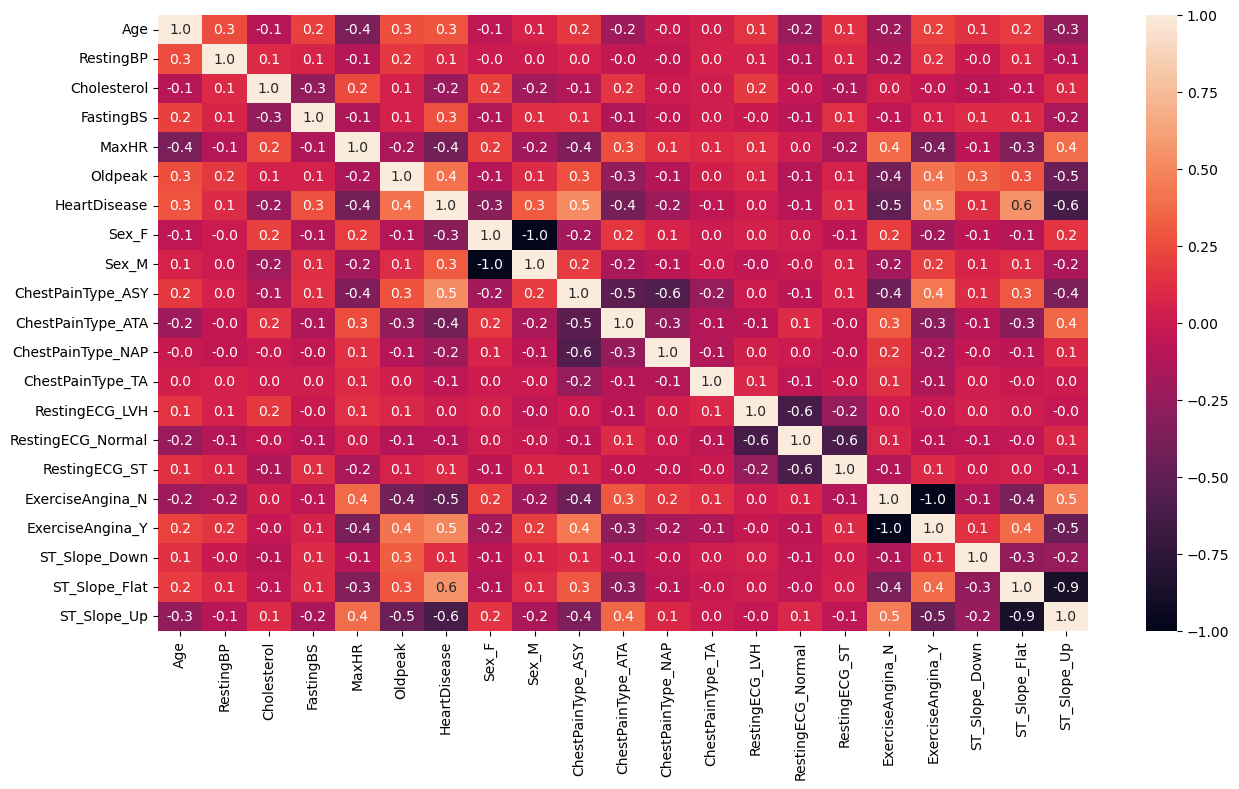

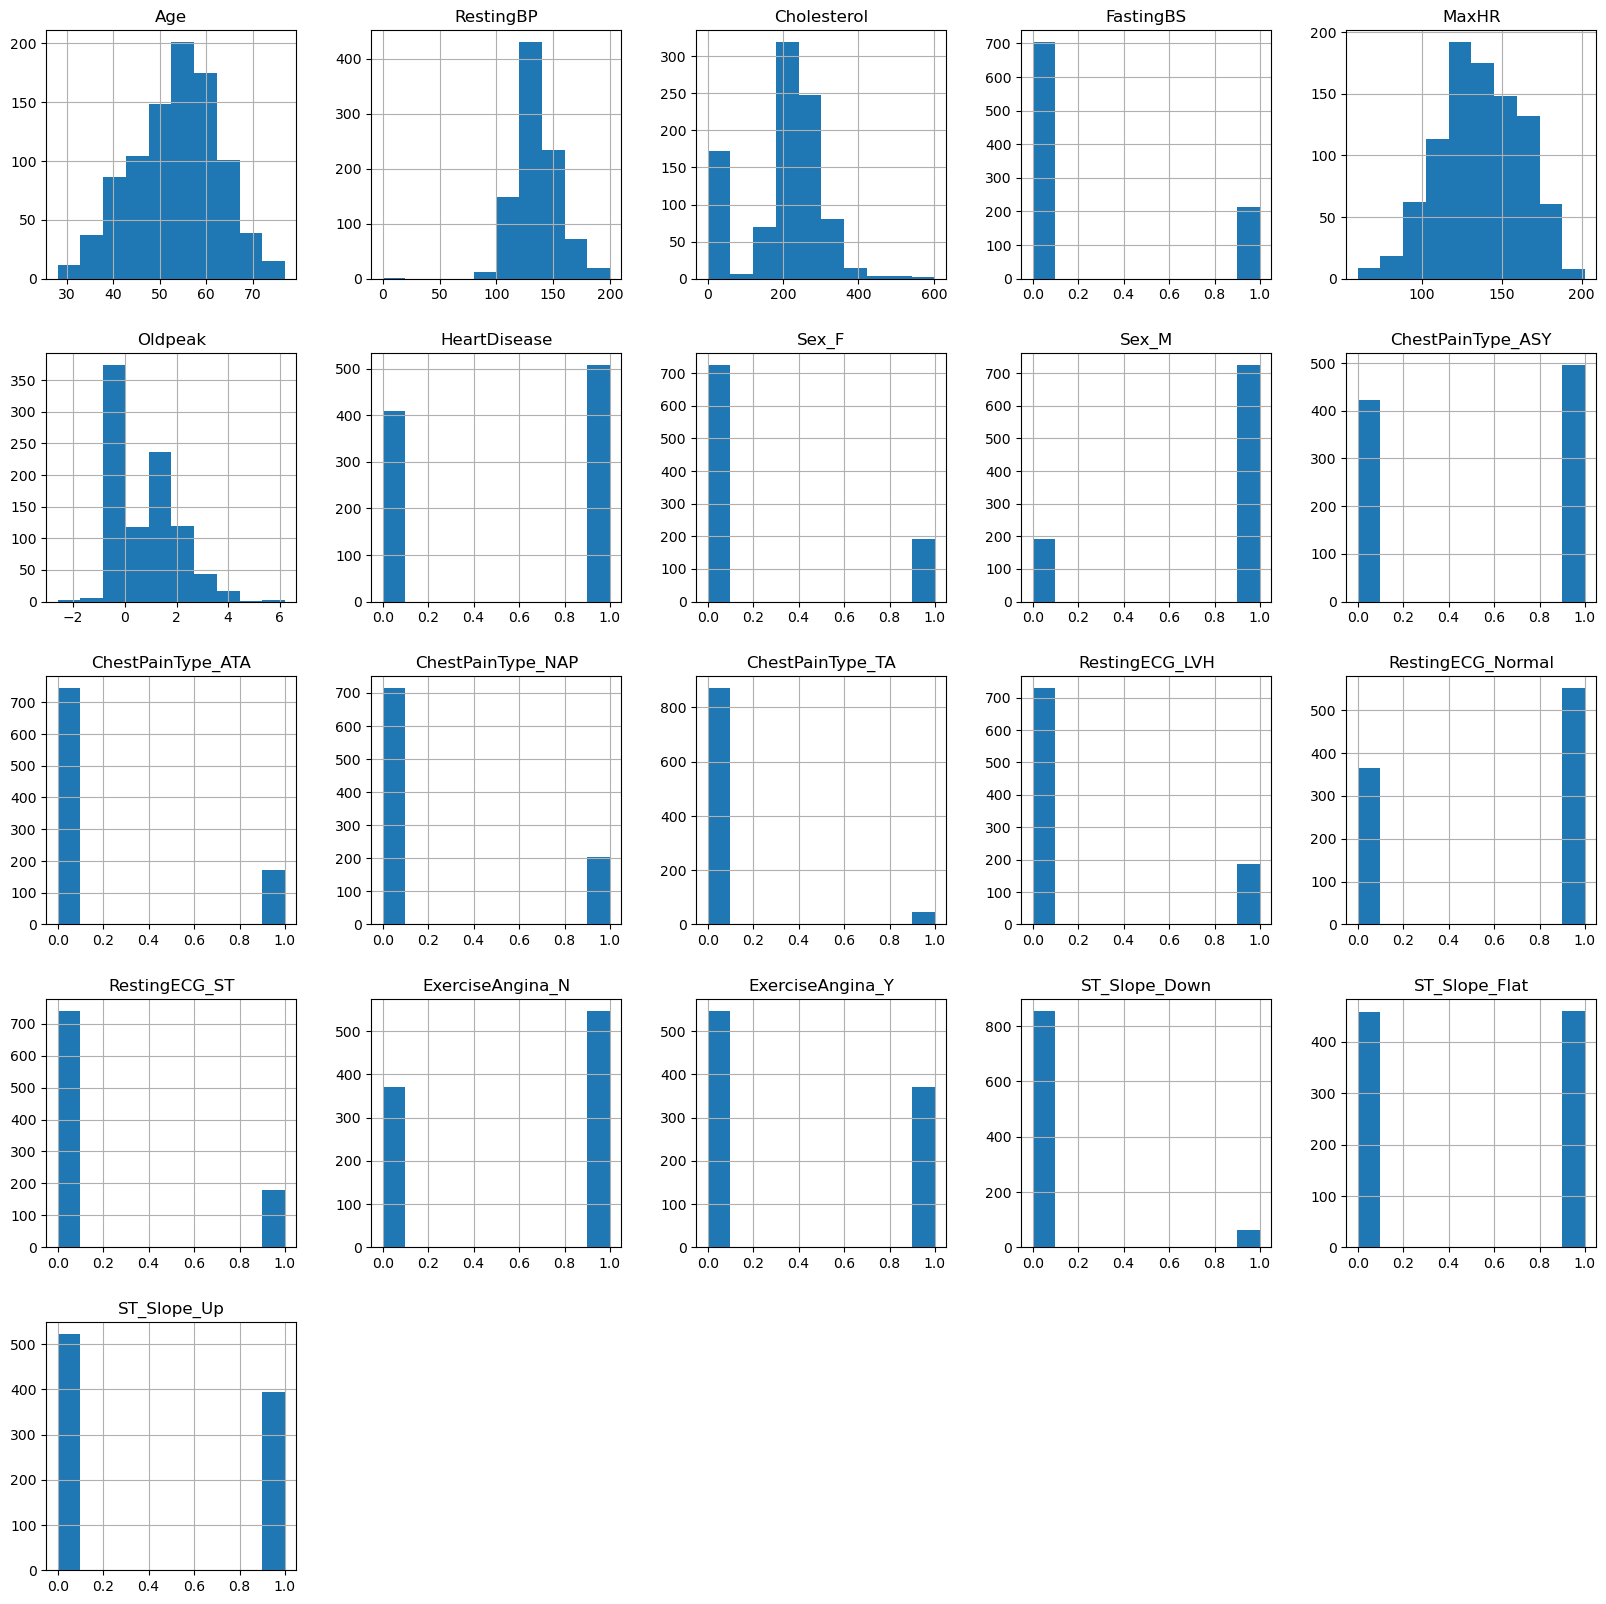

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(df_encoded.corr(), annot=True, fmt='.1f')
df_encoded.hist(figsize=(20,20))